# Introduction to Bootstrapping regression

## Data Science 410

Previously, we have investigated the bootstrap resampling method. We used bootstrap resampling to compute a point estimate and confidence interval for simple univariate statistics.      

The bootstrap method can also be applied to regression models. Computing the bootstrap distribution of the regression model parameters provides insight into variability of these parameters. It is useful to know how much random variation there is in regression coefficients simply because a small change in training data values. 

As with most statistics, it is possible to bootstrap the parameters of most any regression model. However, since bootstrap resampling uses a large number of subsamples, it can be computationally intensive. For large-scale problems it is necessary to using other resampling methods like cross-validation.

To proceed, we need to introduce some new terminology:  

- **Parametric bootstrap:** Linear regression regression is an example of a **parametric model**. Simply, a parametric model is a model with parameters which must be estimated. Bootstrapping to find estimates of these parameters is an example of a parametric bootstrap process. For each bootstrap sample created a new estimate of the model parameters is computed.    
- **Nonparametric bootstrap:** Some statistical estimates have no particular model associated with them. Examples include the mean, variance and bootstrap confidence intervals. These values can be estimated using the bootstrap method without specifying a parametric model. 

## An Example

Let's try an example. We will work with a simple regression model similar to the one used in the one used in the Introduction to Regression notebook. 

As a fist step, execute the code in the cell below to generate the synthetic data set. 

In [2]:
import numpy as np
import numpy.random as nr
import pandas as pd
import statsmodels.formula.api as sm
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Paramters of generated data
n_points = 50
x_start, x_end = 0, 10
y_sd = 1

# Generate data columns
nr.seed(5666)
x_data = np.linspace(x_start, x_end, n_points) # The x values
y_error = np.random.normal(loc=0, scale=y_sd, size=n_points) # The Normally distributed noise
y_data = x_data + y_error + 1.0 # The y values including an intercept

# Put data in dataframe
sim_data = pd.DataFrame({'x':x_data, 'y':y_data})

sim_data.head()

,x,y
0,0.000000,1.475868
1,0.204082,0.915564
2,0.408163,2.216802
3,0.612245,1.362557
4,0.816327,3.521151


Now, plot these data and examine the result by executing the code in the cell below.  

(0, 11)

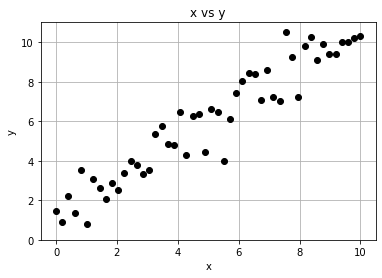

In [4]:
# Matplotlib may give some font errors when loading for the first time, you can ignore these
plt.plot(sim_data['x'], sim_data['y'], 'ko')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y')
plt.ylim(0,11)

### Resample Points (Parametric Bootstrap)

The first type of bootstrapping we will perform is resampling points.

In [5]:
def resample_regression(df, n_boots, n_params=2, formula='y ~ x'):
    ## array to hold the bootstrap samples of the parameters
    boot_samples = np.zeros((n_boots,n_params))
    n_samples = df.shape[0]
    ## Loop over the number of resamples
    for i in range(n_boots):
        ## Create a bootstrap sample of the data frame
        boot_sample = df.sample(n=n_samples, replace = True)
        ## Compute the OLS model
        boot_model = sm.ols(formula=formula, data=boot_sample).fit()
        ## Save the model parameters in the array
        boot_samples[i,:] = boot_model._results.params
    return boot_samples

param_boots = resample_regression(sim_data,1000)
param_boots[:5]

array([[1.13290799, 0.98560489],
       [1.34751537, 0.93057827],
       [1.36160617, 0.94383043],
       [1.1759036 , 0.99644286],
       [1.16683758, 0.99379272]])

You can see the first few bootstrap estimates of the intercept and slope coefficients.     

Let's look at the distributions of the slope and intercepts. Execute the code in the cell below to examine the distribution of the intercept, along with the confidence intervals.

Mean =   1.30
Upper confidence interval =   2.00
Lower confidence interval =   0.56


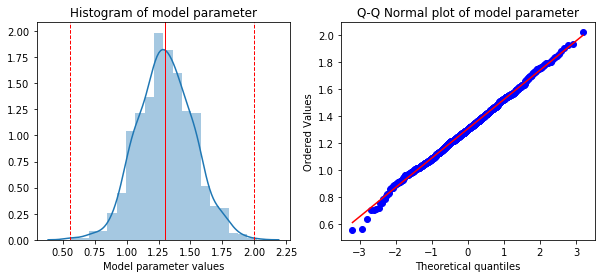

In [6]:
def compute_CI(values, p=0.05):   
    mean = np.mean(values)
    UCI = np.percentile(values, 100-p/2.)
    LCI = np.percentile(values, p/2.)
    print('Mean = %6.2f' % (mean))
    print('Upper confidence interval = %6.2f' % (UCI))
    print('Lower confidence interval = %6.2f' % (LCI))
    return(mean, UCI, LCI)

def plot_boot_params(params):
    mean, UCI, LCI = compute_CI(params)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    sns.distplot(params, bins=20, ax=ax[0])
    ax[0].axvline(mean, color='red', linewidth=1)
    ax[0].axvline(UCI, color='red', linewidth=1, linestyle='--')
    ax[0].axvline(LCI, color='red', linewidth=1, linestyle='--')
    
    ax[0].set_title('Histogram of model parameter')
    ax[0].set_xlabel('Model parameter values')
    ## Plot the Q-Q Normal plot
    ss.probplot(params, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of model parameter')
    plt.show()

plot_boot_params(param_boots[:,0])

Next, execute the code in the cell below to display a plot of the slope parameter, along with the confidence intervals. 

Mean =   0.94
Upper confidence interval =   1.09
Lower confidence interval =   0.83


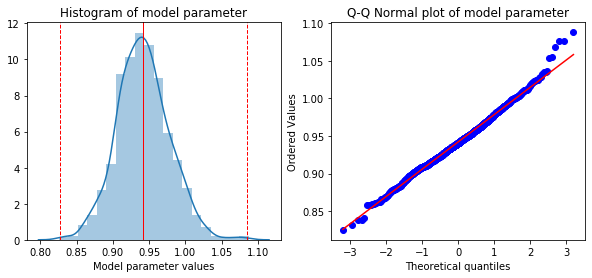

In [7]:
plot_boot_params(param_boots[:,1])

From the plots above you can see the variability and confidence intervals of the parameter estimates. Consider the answers to the following questions:  
1. Are the bootstrap distribution values approximately Normal?
2. Does one coefficient have greater variability than the other, and if so, which one?  
3. Are the known parameter values of the synthetic data within the confidence intervals? 

You can also plot bootstrap realizations of the regression line. This will give you a feel for the variability of the regression solutions. Execute the code in the cell below and examine the result.    

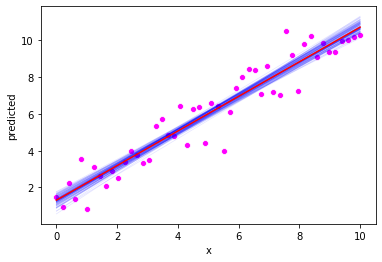

In [13]:
def plot_boot_regression(boot_params, df, n_lines = 100):    
    ## randomly select n_lines to plot
    sample_indx = nr.choice(range(boot_params.shape[0]),n_lines)
    ## Plot the observations
    ax = sns.scatterplot(x='x', y='y', data=df, color = 'magenta')
    ## Loop over the number of bootstrap regression lines to be displayed
    for indx in sample_indx:
        df['predicted'] = boot_params[indx,0] + np.multiply(boot_params[indx,1],df['x'])
        sns.lineplot(x='x', y='predicted', data=df, color='Blue', size = 1.0, alpha=0.1, ax=ax)
    ## Find the mean slope and intercept and plot the line 
    means = np.mean(boot_params, axis=0)
    df['predicted'] = means[0] + np.multiply(means[1],df['x'])
    sns.lineplot(x='x', y='predicted', data=df, color='red', ax=ax)
    ax.get_legend().remove()
    
plot_boot_regression(param_boots, sim_data)    

The plot above shows the following:   
1. The heavy line is the mean parameter regression line.   
2. The light blue lines show a selected number of the bootstrap regression lines. Notice the variability in these possible models. 

# Your Turn

### Question:

From the above sets of 100 slopes and 100 intercepts, what would be a good 90% confidence interval for our slope and intercept?

In [9]:
# Hint: think of sorting the slopes and intercepts first.

But our data is very nice here.  If by chance we had sparse data, there may be a chance that our random selection of points are entirely in one area and not in another.  To combat this, we can apply a different type of bootstrapping, called 'Non-Parametric Bootstrapping' in which we will apply bootstrapping on the residuals.

### Resample Residuals (Non-Parametric Bootstrapping)

The idea is that we want to observe a point at every x-position that we have a point in the original data.  So we fit the original data and re-shuffle the residuals at every point.  This should be fine because we are assuming that the errors are i.i.d. among our points.

In [10]:
# Create sample data
n_points = 25
x = np.linspace(0, 10, n_points)
y = x + (np.random.rand(len(x)) * 5)
data_df = pd.DataFrame({'x': x, 'y': y})

# Fit linear regression model
ols_model = sm.ols(formula = 'y ~ x', data=data_df)
results = ols_model.fit()

# Get predicted values
y_pred = results.predict(x)

# Get residual values
resids = results.resid

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
    y ~ x
        ^

Now that we have the fitted values and residuals from our fit, we will generate N (100) new sets of data by sampling the residuals and adding them to the fitted values.

In [ ]:
boot2_slopes = []
boot2_interc = []
n_boots = 100
plt.figure()
for _ in range(n_boots):
    # Create a sampling of the residuals with replacement
    boot_resids = np.random.choice(resids, n_points, replace=True)
    y_temp = [y_pred_i + resid_i for y_pred_i, resid_i in zip(y_pred, boot_resids)]
    
    sample_df = pd.DataFrame({'x': list(x), 'y': y_temp})
    # Fit a linear regression
    ols_model_temp = sm.ols(formula = 'y ~ x', data=sample_df)
    results_temp = ols_model_temp.fit()
    
    # Get the intercept and slope, and record it
    boot2_interc.append(results_temp.params[0])
    boot2_slopes.append(results_temp.params[1])
    
    # Plot a greyed out line
    y_pred_temp = ols_model_temp.fit().predict(sample_df['x'])
    plt.plot(sample_df['x'], y_pred_temp, color='grey', alpha=0.2)

# Add points
plt.scatter(x, y)
plt.plot(x, y_pred, linewidth=2)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y')

Let's look again at the distributions of the parameters:

In [ ]:
sns.distplot(boot2_slopes)

In [ ]:
sns.distplot(boot2_interc)